In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

torch.manual_seed(1)

#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors

## Load data
source is https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [2]:
data_path = '/Users/tyler/Documents/programming/pytorch_nlp/data/word2vec-nlp-tutorial/'

In [3]:
df = pd.read_csv(data_path+'labeledTrainData.tsv',sep='\t')

In [4]:
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
train = df[:15000]
val = df[15000:20000]
test = df[20000:]

In [6]:
len(train),len(val),len(test)

(15000, 5000, 5000)

In [7]:
def process_review(review):
    chars = ['/','\\','>','<','-','br']
    chars.extend('1 2 3 4 5 6 7 8 9 0'.split())
    for char in chars:
        review = review.replace(char,'')
    
    tokens = word_tokenize(review)
    tokens = [t.lower() for t in tokens]
    return tokens

## Make vocab and train data

In [8]:
labels = list(train.sentiment)
reviews = list(train.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

train_data = list(zip(all_words,labels))

flat_list = [item for sublist in all_words for item in sublist]
vocab = set(flat_list)

len(vocab)

counts = Counter(flat_list).most_common()

start = 10
keep = counts[start:20000+start]

vocab = [word for word,count in keep]
vocab.append('UNK')

word_to_idx = {word:idx for idx,word in enumerate(list(vocab))}
idx_to_word = {idx:word for word,idx in word_to_idx.items()}

## Make validation and test data

In [16]:
labels = list(test.sentiment)
reviews = list(test.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

test_data = list(zip(all_words,labels))

In [17]:
labels = list(val.sentiment)
reviews = list(val.review.values)

all_words = [process_review(review) for review in tqdm(reviews)]

val_data = list(zip(all_words,labels))

## Use pretained word vectors

In [18]:
path = '/Users/tyler/Documents/programming/embeddings/models/glove.840B.300d.model'
glove = KeyedVectors.load_word2vec_format(path,limit=100000)
weights = torch.FloatTensor(glove.vectors)

In [111]:
glove.vectors.shape

(100000, 300)

In [22]:
glove.index2word[5]

'of'

In [23]:
word2idx = {word:idx for idx,word in enumerate(glove.vocab.keys())}

In [24]:
def make_input(sentence, word2idx):
    vec = torch.zeros(len(word2idx),dtype=torch.long)
    for word in sentence:
        if word in word2idx:
            vec[word2idx[word]] = 1
    return vec.view(1, -1)

In [46]:
def make_wv_input(sentence, word2idx):
    vec = []
    for word in sentence:
        if word in word2idx:
            vec.append(glove[word])
    vec = np.vstack(vec)
    ten = torch.tensor(vec,dtype=torch.float)
    return ten

In [48]:
sentence = 'this is a sentence'.split()
ten = make_wv_input(sentence, word2idx)

In [25]:
def make_padded_input(sentence, word2idx):
    max_len = 500
    vec = np.zeros((max_len,300))
    vec_idx = 0
    vec = []
    for word in sentence:
        if vec_idx < max_len:
            if word in glove:
                #vec[vec_idx] = glove[word]
                vec.append(glove[word])
                vec_idx += 1
    vec = np.vstack(vec)
    vec = vec.mean(axis=0)
    ten = torch.tensor(vec,dtype=torch.float)
    
    return ten

In [26]:
sentence = ', , this is a sentence asdf'.split()
x = make_padded_input(sentence, word2idx)

In [27]:
x.shape

torch.Size([300])

In [64]:
class lstm_clf(nn.Module):
    def __init__(self, num_labels, vocab_size, embedding_dim, hidden, weight,max_len):
        
        super(lstm_clf, self).__init__()
        self.hidden_dim = hidden
        self.embedding_dim = embedding_dim
        self.linear = nn.Linear(embedding_dim * max_len, self.hidden_dim)
        self.linear_2 = nn.Linear(self.hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=.3)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weight))
        self.embedding.requires_grad = False
        
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=1,batch_first=True)
        self.hidden = self.init_hidden()

    def forward(self, inputs,h):
        x = inputs.view(1,-1)
        x = x.view(1,-1,self.embedding_dim)
        #embeds = self.embedding(torch.LongTensor(inputs))
        #embeds = embeds.view(1,-1,self.embedding_dim)
        lstm_out, h = self.lstm(x,h)
        #print(lstm_out.shape)
        
        x = self.linear_2(lstm_out[:,-1])
        #x = self.dropout(x)
        probs = F.softmax((x), dim=1)
        return probs[0],h
    
    def init_hidden(self):
        #return (autograd.Variable(torch.zeros(1, 1, size)),autograd.Variable(torch.zeros(1, 1, size)))
        batch_size = 1
        h0 = torch.zeros((1,batch_size,self.hidden_dim))
        c0 = torch.zeros((1,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [130]:
NUM_LABELS = 2
VOCAB_SIZE = 100000
embedding_dim = 300
hidden = 100
max_len = 50

model = lstm_clf(NUM_LABELS, VOCAB_SIZE,embedding_dim,hidden,glove.vectors,max_len)


loss_function = nn.NLLLoss()
loss_function = nn.BCELoss()

lr = .001
#optimizer = optim.SGD(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [66]:
sentence = ', , this is a sentence asdf'.split()
x = make_padded_input(sentence, word2idx)
x = make_input(sentence, word2idx)

sentence = 'this is a sentence'.split()
x = make_wv_input(sentence, word2idx)

In [67]:
x.shape

torch.Size([4, 300])

In [68]:
x = x.view(1,-1,300)
#embeds = self.embedding(torch.LongTensor(inputs))
#embeds = embeds.view(1,-1,self.embedding_dim)
lstm_out, h = model.lstm(x,h)

In [69]:
lstm_out.shape

torch.Size([1, 4, 100])

In [70]:
h = model.init_hidden()
probs,h = model(x,h)

In [172]:
len(val_data)

5000

In [123]:
from datetime import datetime

In [129]:
train_data[0][0][:10]

['with',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with']

In [131]:
train_start = datetime.now()

save_path = 'model_checkpoints/glove_lstm.pt'
val_loss_min = np.Inf
#val_loss_min = 0.694
num_epochs = 5
num_examples = 500
loss_history = []
for epoch in range(num_epochs):
    train_loss = []
    
    h = model.init_hidden()
    
    for sentence, label in train_data[:num_examples]:
        h = tuple([each.data for each in h])
        
        model.zero_grad()

        vec = make_wv_input(sentence, word2idx)
        
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)

        probs,h = model(vec,h)
        loss = loss_function(probs, target)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        
    mean_train_loss = np.mean(train_loss)
    val_loss = []
    
    h = model.init_hidden()
    
    for sentence, label in val_data[:num_examples]:
        h = tuple([each.data for each in h])
        
        model.eval()

        vec = make_wv_input(sentence, word2idx)
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)
        
        probs,h = model(vec,h)
        loss = loss_function(probs, target)
        pred = probs.argmax().detach().numpy()

        val_loss.append(loss.item())
        
    mean_val_loss = np.mean(val_loss)
    
    loss_history.append((mean_train_loss,mean_val_loss))
    print(f'Epoch {epoch+1}/{num_epochs}: train loss of {mean_train_loss:.3f}, val loss of {mean_val_loss:.3f}')
    
    if mean_val_loss <= val_loss_min:
        print(f'Val loss decreased {val_loss_min:.3f} --> {mean_val_loss:.3f} saving model...')
        torch.save(model.state_dict(),save_path)
        val_loss_min = mean_val_loss

train_end = datetime.now()
diff = (train_end - train_start).seconds
print(f'{diff} seconds to train')

Epoch 1/5: train loss of 0.700, val loss of 0.681
Val loss decreased inf --> 0.681 saving model...
Epoch 2/5: train loss of 0.687, val loss of 0.683
Epoch 3/5: train loss of 0.587, val loss of 0.764
Epoch 4/5: train loss of 0.434, val loss of 0.855
Epoch 5/5: train loss of 0.285, val loss of 0.947
365 seconds to train


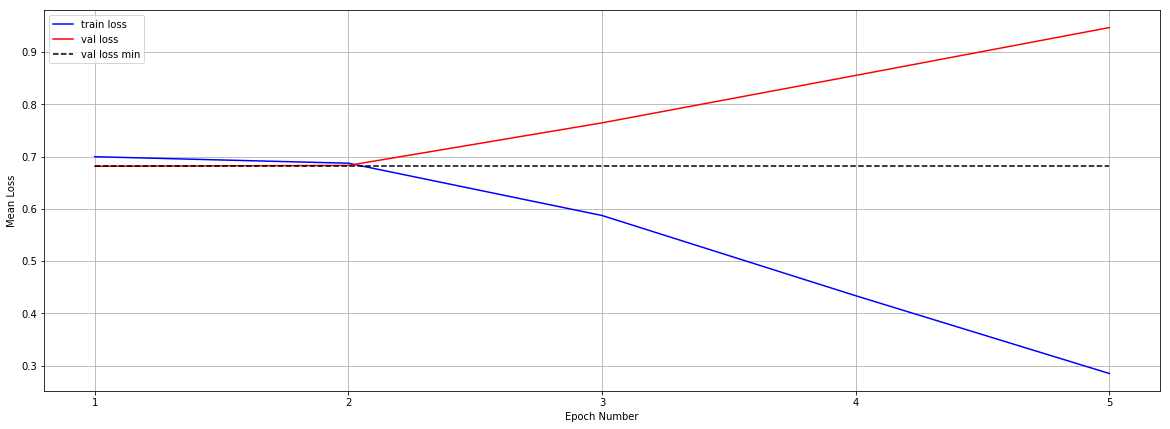

In [132]:
loss_array = np.array(loss_history)
train_loss = loss_array[:,0]
val_loss = loss_array[:,1]

x = np.arange(1,loss_array.shape[0]+1)
y = train_loss
plt.plot(x,y,c='blue',label='train loss')

x = np.arange(1,loss_array.shape[0]+1)
y = val_loss
plt.plot(x,y,c='red',label='val loss')

x0 = np.array([1,loss_array.shape[0]])
y0 = np.array([val_loss_min,val_loss_min])
plt.plot(x0,y0,c='black',label='val loss min',linestyle='--')

plt.grid(which='both') 
plt.legend()
fig,ax = plt.gcf(),plt.gca()
ax.set_xticks(x)
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Mean Loss')

fig.set_size_inches(20,7)

## Evaluate Model

In [133]:
names = 'train val test'.split()
num = 500
data_list = [train_data[:num],val_data[:num],test_data[:num]]
#data_list = [train_data,val_data,test_data]

for name,data in zip(names,data_list):
    eval_loss = []
    num_correct = 0
    to_eval = test_data
    
    h = model.init_hidden()
    
    for sentence, label in data:
        h = tuple([each.data for each in h])
        
        model.eval()

        vec = make_wv_input(sentence, word2idx)        
        if label == 0:
            target = torch.tensor([1,0],dtype=torch.float)
        else:
            target = torch.tensor([0,1],dtype=torch.float)

        probs,h = model(vec,h)
        loss = loss_function(probs, target)
        
        pred = probs.argmax().detach().numpy()
        correct = int(pred == label)
        num_correct += correct
        loss = loss_function(probs, target)

        eval_loss.append(loss.item())
    
    mean_loss = np.mean(eval_loss)
    print(f'----{name} set----'.upper())
    print(f'{name} loss of {round(mean_loss,3)}')
    print(f'{name} accuracy of {round(num_correct*100/len(data),2)}')


----TRAIN SET----
train loss of 0.2
train accuracy of 91.8
----VAL SET----
val loss of 0.947
val accuracy of 64.0
----TEST SET----
test loss of 0.959
test accuracy of 62.4


In [93]:
sentence = 'i liked the movie'.split()
vec = make_wv_input(sentence, word2idx) 

probs,h = model(vec,h)
loss = loss_function(probs, target)

pred = probs.argmax().detach().numpy()

In [106]:
sentence = 'this movie rocks'.split()
predict_sentence(sentence,word2idx,model)

array(1)

In [107]:
sentence = 'this movie sucks'.split()
predict_sentence(sentence,word2idx,model)

array(0)

In [97]:
def predict_sentence(sentence,word2idx,model):
    vec = make_wv_input(sentence, word2idx) 
    
    h = model.init_hidden()
    h = tuple([each.data for each in h])
    
    probs,h = model(vec,h)
    loss = loss_function(probs, target)

    pred = probs.argmax().detach().numpy()
    
    return pred